In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

class StraightLine(nn.Module):
    def __init__(self, samples=100):
        super().__init__()
        self.muM = nn.Parameter(torch.tensor(1.0))
        self.sigmaM = nn.Parameter(torch.tensor(1.0))
        self.muB = nn.Parameter(torch.tensor(1.0))
        self.sigmaB = nn.Parameter(torch.tensor(1.0))
        
        self.samples = samples
    
    def forward(self, x):        
        self.m = self.muM + torch.exp(self.sigmaM) * Normal(0, 1).sample(torch.Size([1, self.samples]))
        self.b = self.muB + torch.exp(self.sigmaB) * Normal(0, 1).sample(torch.Size([1, self.samples]))

        return torch.matmul(x, self.m) + self.b.repeat(x.shape[0], 1)

class VariationalBayes(nn.Module):
    def __init__(self, sl_samples=100):
        super().__init__()
        self.f = StraightLine(samples=sl_samples)
        self.sigmaN = nn.Parameter(torch.tensor(1.0))
        self.prior_M_std = torch.tensor([1.])
        self.prior_B_std = torch.tensor([10.])
        
    def forward(self, x, y):
        pred = self.f(x)
        
        y_truth = y.reshape(y.shape[0], -1).repeat(1, self.f.samples)
        nLogLik = (-1.) * Normal(pred, self.sigmaN).log_prob(y_truth).sum() / self.f.samples

        nLogPriorM = torch.log(self.prior_M_std) + 0.5 * (self.f.muM / self.prior_M_std) ** 2 + 0.5 * (self.f.sigmaM / self.prior_M_std) ** 2
        nLogPriorB = torch.log(self.prior_B_std) + 0.5 * (self.f.muB / self.prior_B_std) ** 2 + 0.5 * (self.f.sigmaB / self.prior_B_std) ** 2
        
        LogVarPostM = (-1.) * torch.log(self.f.sigmaM) 
        LogVarPostB = (-1.) * torch.log(self.f.sigmaB)
    
        return LogVarPostM + LogVarPostB + nLogLik + nLogPriorM + nLogPriorB

class LinearRegression:
    def __init__(self):
        self.m_ = None
        self.sigM_ = None
        self.b_ = None
        self.sigB_ = None
        self.n_ = None

        self.params = {
            'line_samples': 100,
            'epochs': 10000,
            'learning_rate': 0.02,
            'pred_samples': 100,
            'score_samples': 100,
            'plot_samples': 1000
        }
    
    def set_params(self, **params):
        self.params.update(params)
    
    def get_params(self):
        return self.params

    def fit(self, x, y):
        model = VariationalBayes(self.params['line_samples'])
        optimizer = optim.Adam(model.parameters(), lr = self.params['learning_rate'])

        x_tensor = Variable(torch.from_numpy(x).type(torch.FloatTensor)) # type: ignore
        y_tensor = Variable(torch.from_numpy(y).type(torch.FloatTensor)) # type: ignore

        for epoch in tqdm(range(self.params['epochs']), desc="Training..."):
            optimizer.zero_grad()
            
            nLogLik = model(x_tensor, y_tensor)
            nLogLik.backward(retain_graph=True)

            optimizer.step()
        
        self.m_ = model.f.muM
        self.sigM_ = model.f.sigmaM
        self.b_ = model.f.muB
        self.sigB_ = model.f.sigmaB
        self.n_ = model.sigmaN

    
    def predict(self, x):
        x_tensor = Variable(torch.from_numpy(x).type(torch.FloatTensor)) # type: ignore

        m = self.m_ + torch.exp(self.sigM_) * Normal(0, 1).sample(torch.Size([1, self.params['pred_samples']])) # type: ignore
        b = self.b_ + torch.exp(self.sigB_) * Normal(0, 1).sample(torch.Size([1, self.params['pred_samples']])) # type: ignore

        return torch.matmul(x_tensor, m) + b.repeat(x_tensor.shape[0], 1)
    
    def score(self, x, y):
        x_tensor = Variable(torch.from_numpy(x).type(torch.FloatTensor)) # type: ignore
        y_tensor = Variable(torch.from_numpy(y).type(torch.FloatTensor)) # type: ignore
    
        m = self.m_ + torch.exp(self.sigM_) * Normal(0, 1).sample(torch.Size([1, self.params['score_samples']])) # type: ignore
        b = self.b_ + torch.exp(self.sigB_) * Normal(0, 1).sample(torch.Size([1, self.params['score_samples']])) # type: ignore

        pred = torch.matmul(x_tensor, m) + b.repeat(x_tensor.shape[0], 1)

        rss = torch.sum((y_tensor - pred) ** 2)
        tss = torch.sum((y_tensor - torch.mean(y_tensor)) ** 2)
        return 1 - rss / tss

    def plot(self):
        # Setup the x range
        x = np.linspace(-10, 10, self.params['plot_samples'])

        # plot the distribution
        m = self.m_ + torch.exp(self.sigM_) * Normal(0, 1).sample(torch.Size([1, self.params['plot_samples']])).reshape(-1) # type: ignore
        b = self.b_ + torch.exp(self.sigB_) * Normal(0, 1).sample(torch.Size([1, self.params['plot_samples']])).reshape(-1) # type: ignore
        
        m = m.detach().numpy()
        b = b.detach().numpy()

        for i in range(self.params['plot_samples']):
            y = m[i] * x + b[i]
            plt.plot(x, y, color='blue', alpha=0.1)
        
        # plot the line
        y = self.m_.detach().numpy() * x + self.b_.detach().numpy() # type: ignore
        plt.plot(x, y, color='red')

In [126]:
import pandas as pd

# Read the data
FILE_PATH = 'data/Advertising.csv' 
df = pd.read_csv(FILE_PATH).drop('Unnamed: 0', axis=1)

# Obtains our x and y vectors
x = df.TV.to_numpy().reshape(-1, 1)
y = df.Sales.to_numpy().reshape(-1, 1)

In [127]:
from sklearn.model_selection import train_test_split

# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Create the model
model = LinearRegression()

# Train the model
model.fit(x_train, y_train)

model.m_, model.sigM_, model.b_, model.sigB_, model.n_

Training...: 100%|██████████| 10000/10000 [00:18<00:00, 546.68it/s]


(Parameter containing:
 tensor(0.0503, requires_grad=True),
 Parameter containing:
 tensor(-3.7168, requires_grad=True),
 Parameter containing:
 tensor(6.7563, requires_grad=True),
 Parameter containing:
 tensor(0.0659, requires_grad=True),
 Parameter containing:
 tensor(3.3182, requires_grad=True))

In [128]:
# Make predictions
pred = model.predict(x_test)

# Compute the score
model.score(x_test, y_test)

tensor(-129.5175, grad_fn=<RsubBackward1>)

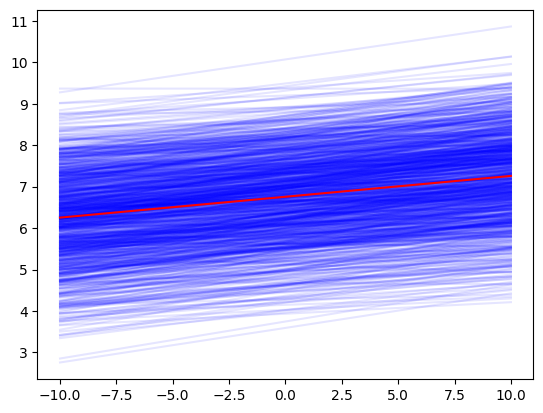

In [129]:
model.plot()